# Synthetic Data Generation for Weather Data with SDV

### This notebook explores the creation of synthetic data for a time-series dataset. The aim of synthetic generation for this particular case is to improve accuracy as well as fill in the gaps in the dataset.

In [12]:
import pandas as pd
from sdv.sequential import PARSynthesizer
from sdv.metadata import SingleTableMetadata
import matplotlib.pyplot as plt

In [40]:
real_data = pd.read_csv('datasets/weatherdata.csv')

### Exploratory Data Analysis

In [43]:
# Renaming the columns for better readability
real_data.rename(columns={'value1':'temperature','value2':'humidity','value3':'pressure'}, inplace=True)

# Converting the reading_time datatype from Object to datetime.
real_data['reading_time'] = pd.to_datetime(real_data['reading_time'])

# Removing invalid sensor readings that return a value of 180 for temperature
real_data.drop(real_data[real_data['temperature'] >= 60].index, inplace = True)

real_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791 entries, 0 to 883
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            791 non-null    int64         
 1   sensor        791 non-null    object        
 2   location      791 non-null    object        
 3   temperature   791 non-null    float64       
 4   humidity      791 non-null    float64       
 5   pressure      791 non-null    float64       
 6   reading_time  791 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 49.4+ KB


The mean temperature is: 27.561428571428568


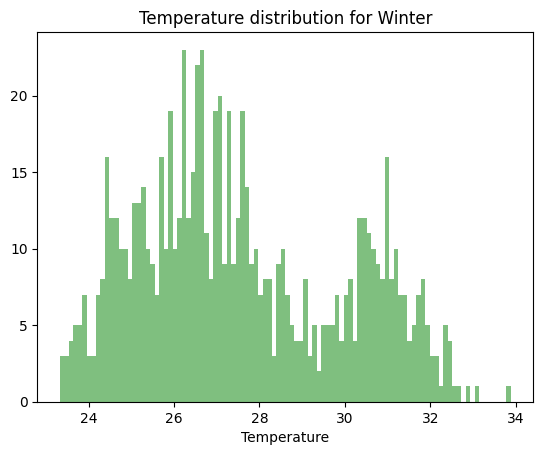

In [54]:
# Viewing Normal Distribution of Temperature 

kwargs = dict(alpha=0.5, bins=100)
plt.hist(real_data['temperature'], **kwargs, color='g', label='Temperature distribution')
plt.gca().set(title='Temperature distribution for Winter', xlabel='Temperature')
print(f"The mean temperature is: {real_data['temperature'].mean()}")
plt.show()

### Fitting our data to SDV's requirements

In [55]:
# Auto-detecting metadata for our dataset

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data)

metadata

{
    "columns": {
        "id": {
            "sdtype": "numerical"
        },
        "sensor": {
            "sdtype": "categorical"
        },
        "location": {
            "sdtype": "categorical"
        },
        "temperature": {
            "sdtype": "numerical"
        },
        "humidity": {
            "sdtype": "numerical"
        },
        "pressure": {
            "sdtype": "numerical"
        },
        "reading_time": {
            "sdtype": "datetime"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [56]:
# Updating the reading_time column as this will be our sequence index
metadata.update_column(
    column_name='reading_time',
    sdtype='datetime',
    datetime_format='%Y-%m-%d %H:%M:%S'
)

# Updating the sensor column as this will be our sequence key
metadata.update_column(
    column_name='sensor',
    sdtype='id',
    regex_format='[A-Z]{4}'
)

In [57]:
metadata.set_sequence_index(column_name='reading_time')
metadata.set_sequence_key(column_name='sensor')

In [59]:
# Finalized metadata
metadata

{
    "columns": {
        "id": {
            "sdtype": "numerical"
        },
        "sensor": {
            "sdtype": "id",
            "regex_format": "[A-Z]{4}"
        },
        "location": {
            "sdtype": "categorical"
        },
        "temperature": {
            "sdtype": "numerical"
        },
        "humidity": {
            "sdtype": "numerical"
        },
        "pressure": {
            "sdtype": "numerical"
        },
        "reading_time": {
            "sdtype": "datetime",
            "datetime_format": "%Y-%m-%d %H:%M:%S"
        }
    },
    "sequence_key": "sensor",
    "sequence_index": "reading_time",
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [94]:
custom_synthesizer = PARSynthesizer(
    metadata,
    context_columns=['location'], # Context columns are those that do not change in a sequence.
    epochs = 110,
    verbose = True
    )
custom_synthesizer.fit(real_data)

/Users/deveshparagiri/weather_synthetic_generation/env/lib/python3.9/site-packages/sdv/sequential/par.py:138: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for sequence_key_value, data_values in data.groupby(self._sequence_key):
Epoch 110 | Loss 72.33970642089844: 100%|██████████| 110/110 [00:12<00:00,  8.59it/s] 


In [113]:
synthetic_data = custom_synthesizer.sample(num_sequences=1, sequence_length=700)
synthetic_data.head()

100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


,id,sensor,location,temperature,humidity,pressure,reading_time
0,287,AMSV,Home,29.280451,75.812023,1010.260733,2023-01-30 16:00:47
1,418,AMSV,Home,31.639503,64.586066,1009.093109,2023-01-30 16:47:41
2,254,AMSV,Home,29.580187,63.250066,1008.996108,2023-01-30 17:34:35
3,329,AMSV,Home,30.126177,75.812023,1010.738272,2023-01-30 19:48:17
4,252,AMSV,Home,28.002727,65.136935,1010.348951,2023-01-30 22:53:10


The mean temperature is: 26.07623110696581


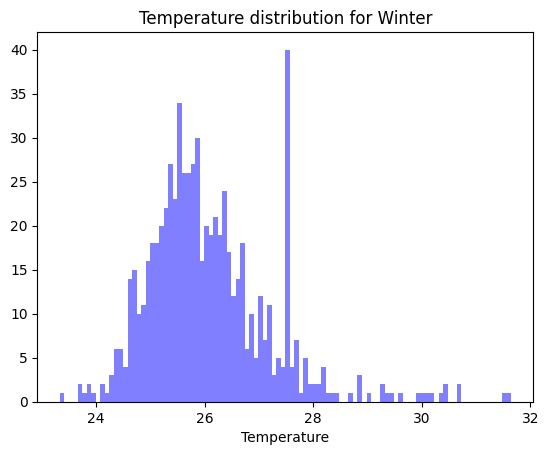

The mean temperature is: 27.561428571428568


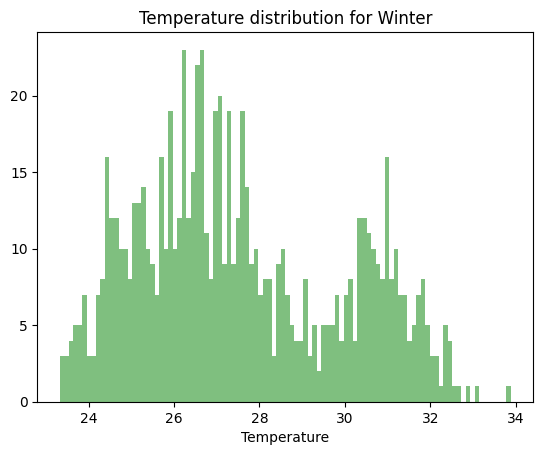

In [114]:
# Viewing Normal Distribution of Temperature for synthetic data 

kwargs = dict(alpha=0.5, bins=100)
plt.hist(synthetic_data['temperature'], **kwargs, color='b', label='Temperature distribution')
plt.gca().set(title='Temperature distribution for Winter', xlabel='Temperature')
print(f"The mean temperature is: {synthetic_data['temperature'].mean()}")
plt.show()

kwargs = dict(alpha=0.5, bins=100)
plt.hist(real_data['temperature'], **kwargs, color='g', label='Temperature distribution')
plt.gca().set(title='Temperature distribution for Winter', xlabel='Temperature')
print(f"The mean temperature is: {real_data['temperature'].mean()}")
plt.show()

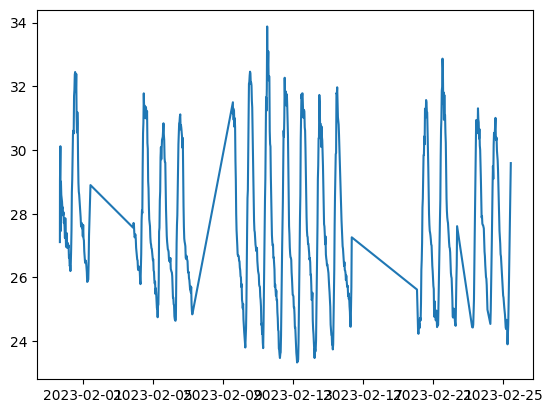

In [115]:
plt.plot(real_data['reading_time'],real_data['temperature'])

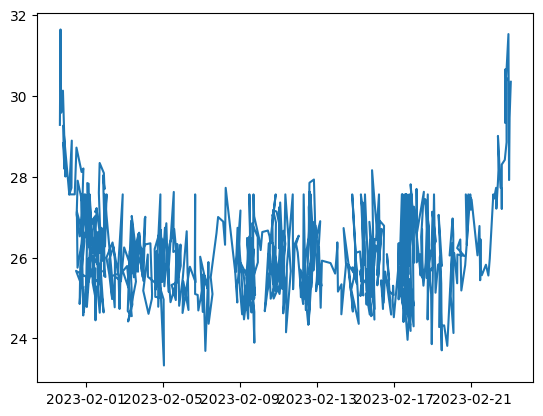

In [116]:
plt.plot(synthetic_data['reading_time'],synthetic_data['temperature'])